In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, SeparableConv2D, ReLU
import model_architectures as model_archs
import time

# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
## Print out some system information
import subprocess

print('Linux kernel version:')
print('$ uname -r')
result = subprocess.run(['uname', '-r'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

print('Linux release:')
print('$ lsb_release -a')
result = subprocess.run(['lsb_release', '-a'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

print('Tensorflow python module version')
print(tf.__version__)
print('')

print('Edge TPU python module version:')
import edgetpu
print(edgetpu.__version__)
print('')

print('Edge TPU compiler version:')
result = subprocess.run(['edgetpu_compiler', '--version'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

print('Edge TPU runtime version:')
import edgetpu.basic.edgetpu_utils
print(edgetpu.basic.edgetpu_utils.GetRuntimeVersion())
print('')

print('Paths of available Edge TPU devices, if any:')
print(edgetpu.basic.edgetpu_utils.ListEdgeTpuPaths(edgetpu.basic.edgetpu_utils.EDGE_TPU_STATE_NONE))

Linux kernel version:
$ uname -r
4.4.0-96-generic

Linux release:
$ lsb_release -a
Distributor ID:	Ubuntu
Description:	Ubuntu 16.04.6 LTS
Release:	16.04
Codename:	xenial

Tensorflow python module version
1.15.0

Edge TPU python module version:
2.12.1

Edge TPU compiler version:
Edge TPU Compiler version 2.0.267685300

Edge TPU runtime version:
BuildLabel(COMPILER=5.4.0 20160609,DATE=redacted,TIME=redacted,CL_NUMBER=267685300), RuntimeVersion(12)

Paths of available Edge TPU devices, if any:
('/sys/bus/usb/devices/2-9',)


In [3]:
if tf.__version__.startswith('1.15'):
    # This prevents some errors that otherwise occur when converting the model with TF 1.15...
    tf.enable_eager_execution() # Only if TF is version 1.15    

In [4]:
## Build a very simple model
image_shape = (56,56, 32)

def representative_dataset_gen():
    num_calibration_images = 10
    for i in range(num_calibration_images):
        image = tf.random.normal([1] + list(image_shape))
#         image = tf.random.uniform([1] + list(image_shape), dtype=tf.dtypes.float32)
#         image = tf.random.uniform([1] + list(image_shape)) * 256
#         image = tf.dtypes.cast(image, tf.uint8)

        yield [image]

# Include whichever type of layer(s) you want to test out.
x = Input(shape=image_shape)
# y = Conv2D(192, (3, 3), padding='same')(x)
# y = MaxPooling2D(pool_size=(2, 2))(x)
# y = ReLU()(y)
y = SeparableConv2D(192, (3, 3), padding='same')(x)
model = Model(inputs=x, outputs=y)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 32)]      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 56, 56, 192)       6624      
Total params: 6,624
Trainable params: 6,624
Non-trainable params: 0
_________________________________________________________________


In [5]:
## Convert to tensorflow lite model and save...
if tf.__version__.startswith('2.'):
    converter = tf.lite.TFLiteConverter.from_keras_model(model) # TF2.0
elif tf.__version__.startswith('1.15'):
    model.save('model_keras', include_optimizer=False) # TF1.15
    converter = tf.lite.TFLiteConverter.from_keras_model_file('model_keras') # TF1.15
else:
    raise ValueError('Unhandled TensorFlow version.')
    
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_dataset_gen)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # For EdgeTPU, no float ops allowed
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

tflite_model = converter.convert()
open('model.tflite', 'wb').write(tflite_model)

14496

In [6]:
##================================================================================================
## Set variable below and comment out lines in cell below if not using Edge TPU model and hardware
##================================================================================================
# True:  Use EdgeTPU model and process on the Edge TPU (assumes one is available)
# False: Use TFLite model and process on CPU
use_edgetpu = True

In [7]:
%%bash
## Compile model for edge TPU
# Note that the output file name has '_edgetpu' appended to the root filename of the input TFLite model.
edgetpu_compiler --min_runtime_version 12 --show_operations 'model.tflite'

Edge TPU Compiler version 2.0.267685300

Model compiled successfully in 9 ms.

Input model: model.tflite
Input size: 14.16KiB
Output model: model_edgetpu.tflite
Output size: 48.83KiB
On-chip memory available for caching model parameters: 8.03MiB
On-chip memory used for caching model parameters: 9.75KiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 4
Operation log: model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 2
Number of operations that will run on CPU: 2

Operator                       Count      Status

QUANTIZE                       1          Operation is otherwise supported, but not mapped due to 

In [8]:
## Load TFLite model and allocate tensors.
if use_edgetpu:
#     # If using interpreter from tflite_runtime package
#     from tflite_runtime.interpreter import load_delegate
#     from tflite_runtime.interpreter import Interpreter
#     interpreter = Interpreter(model_path='model_edgetpu.tflite',
#                               model_content=None,
#                               experimental_delegates=[load_delegate('libedgetpu.so.1.0')])
    
    # If using interpreter from full TensorFlow package...
    from tensorflow.lite.python.interpreter import load_delegate
    interpreter = tf.lite.Interpreter(model_path='model_edgetpu.tflite',
                                      experimental_delegates=[load_delegate('libedgetpu.so.1.0')])
else:
    interpreter = tf.lite.Interpreter(model_path='model.tflite')

interpreter.allocate_tensors()

# Get input and output tensors details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

Model processing took 0.031252 seconds.
Individual image processing times:
[0.01698232 0.01369596]


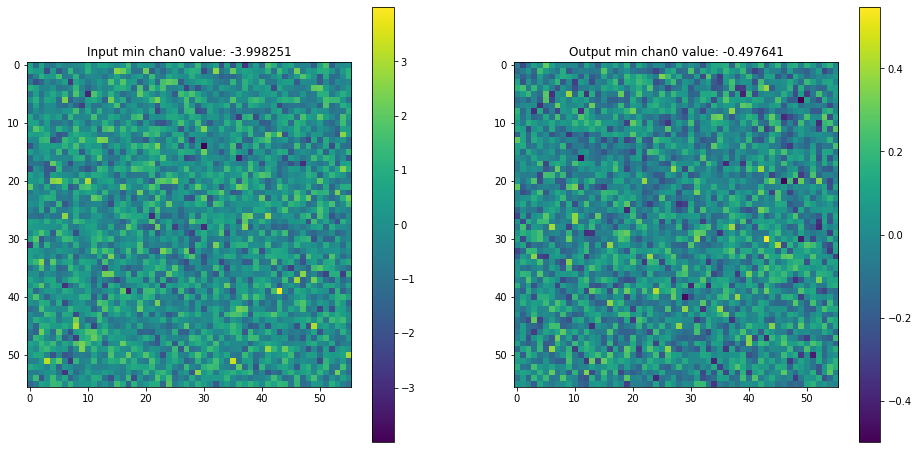

In [9]:
## Put some random data through the model and show results
# Create a batch of images
batch_size = 2
image = tf.random.normal([batch_size] + list(image_shape))
# image = tf.random.uniform([batch_size] + list(image_shape))
# image = tf.random.uniform([batch_size] + list(image_shape)) * 256
# image = tf.dtypes.cast(image, tf.uint8)

# Process the image with the network model
t_all = time.time()
t_individual = np.zeros(batch_size)
for i_im in range(batch_size):
    t_one = time.time()
    # Set input tensor and invoke model
    interpreter.set_tensor(input_details[0]['index'], image[i_im:i_im+1])
    interpreter.invoke()   # Can be slow if running on CPU

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    model_output = interpreter.get_tensor(output_details[0]['index'])
    t_individual[i_im] = time.time() - t_one
print('Model processing took %f seconds.' % (time.time() - t_all))
print('Individual image processing times:')
print(t_individual)

# Plot results for first channel of input and output, of the first
# image in the batch.
in_chan0 = image[0, :, :, 0]
out_chan0 = model_output[0, :, :, 0]
plt.figure(figsize=(16, 8))
clim = [-4, 4]

plt.subplot(1,2,1)
plt.imshow(in_chan0, aspect='equal')
plt.title('Input min chan0 value: %f' % (tf.reduce_min(in_chan0)))
# plt.clim(clim)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(out_chan0, aspect='equal')
plt.title('Output min chan0 value: %f' % (tf.reduce_min(out_chan0)))
# plt.clim(clim)
plt.colorbar()